##### 1.匯入套件與資料讀取

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.stats import zscore
import statsmodels.api as sm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc as sk_auc, recall_score, precision_score, fbeta_score
)
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_recall_curve

from imblearn.over_sampling import SMOTENC
from category_encoders import TargetEncoder

In [2]:
# === 圖表儲存函數 ===
import os
def save_plot(fig, filename, model_name='rf_halving_feature'):  # ← 重新命名
    """
    儲存圖表到 ../results/{model_name}/{filename}
    """
    path = f'../results/{model_name}'
    os.makedirs(path, exist_ok=True)
    fig.savefig(f'{path}/{filename}', dpi=300)

##### 2.讀取資料與切分訓驗測集

In [3]:
df = pd.read_csv('../raw_data/train_2025.csv')
X = df.drop(columns=['claim_number', 'fraud'])  # 移除 ID 與目標欄位
y = df['fraud']
# 切分資料集：60% 訓練、20% 驗證、20% 測試
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

##### 3.資料清洗與特徵欄位分類

In [4]:
# 以下特徵工程跟logit一樣，可省略不看
mask = ~X_train['zip_code'].astype(str).str.startswith('0')
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

cat_cols = [
    'gender', 'marital_status', 'high_education_ind', 'address_change_ind',
    'living_status', 'zip_code', 'claim_date', 'claim_day_of_week', 'accident_site',
    'witness_present_ind', 'channel', 'policy_report_filed_ind', 'vehicle_category', 'vehicle_color'
]
num_cols = [col for col in X_train.columns if col not in cat_cols]

##### 4.自訂欄位轉換器類別與函數

In [5]:
def encode_gender(X): 
    return (X == 'M').astype(int)

def encode_living_status(X): 
    return (X == 'Own').astype(int)

class Zip3Extractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            self.feature_names_in_ = list(X.columns)
        else:
            self.feature_names_in_ = [f"col_{i}" for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.feature_names_in_)
        return X_df.apply(lambda col: col.astype(str).str[:3])

    def get_feature_names_out(self, input_features=None):
        return [f"{feat}_zip3" for feat in (self.feature_names_in_ if input_features is None else input_features)]


class ExtractMonthYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            self.feature_names_in_ = list(X.columns)
        else:
            self.feature_names_in_ = [f"col_{i}" for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_series = pd.DataFrame(X, columns=self.feature_names_in_).iloc[:, 0]
        date = pd.to_datetime(X_series, errors='coerce')
        return date.dt.to_period('M').astype(str).to_frame()

    def get_feature_names_out(self, input_features=None):
        return [f"{feat}_month_year" for feat in (self.feature_names_in_ if input_features is None else input_features)]


class TargetEncoderWrapper(TargetEncoder):
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_in_ if input_features is None else input_features


##### 5.設定各欄位的轉換流程

In [6]:
marital_witness_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent'))])
gender_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', FunctionTransformer(encode_gender, validate=False, feature_names_out='one-to-one'))
])
zip3_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('zip3_extract', Zip3Extractor()),
    ('target', TargetEncoderWrapper())
])
claim_date_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('extract_month_year', ExtractMonthYear()),
    ('target', TargetEncoderWrapper())
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
target_cat_cols = ['living_status', 'claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color']
target_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoderWrapper())
])

transformers = [
    ('marital_witness', marital_witness_pipeline, ['marital_status', 'witness_present_ind']),
    ('gender', gender_pipeline, ['gender']),
    ('zip_code', zip3_pipeline, ['zip_code']),
    ('claim_date', claim_date_pipeline, ['claim_date']),
    ('num', num_pipeline, num_cols),
    ('cat_imputer', target_cat_pipeline, target_cat_cols)
]
preprocessor = ColumnTransformer(transformers, remainder='passthrough')

##### 6.Halving Grid Search 訓練流程

In [7]:
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 4],
    "max_features": ["sqrt"],
    'class_weight': [None, 'balanced']
}
grid = list(ParameterGrid(param_grid))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

max_iter = 6
factor = 2
initial_frac = 1/32
results = []
current_candidates = grid.copy()

start_time = time.time()
for iteration in range(max_iter):
    print(f"\n=== Halving Iteration {iteration}/{max_iter} ===")
    frac = min(initial_frac * (factor ** iteration), 1.0)
    n_samples = int(len(X_train) * frac)
    scores = []

    for param in current_candidates:
        aucs = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr_f = X_train.iloc[train_idx][:n_samples].copy()
            y_tr_f = y_train.iloc[train_idx][:n_samples].copy()
            X_val_f = X_train.iloc[val_idx].copy()
            y_val_f = y_train.iloc[val_idx].copy()
            z_scores = X_tr_f[num_cols].apply(zscore)
            mask_no_outliers = (z_scores.abs() < 3).all(axis=1)
            X_tr_f = X_tr_f.loc[mask_no_outliers].reset_index(drop=True)
            y_tr_f = y_tr_f.loc[mask_no_outliers].reset_index(drop=True)
            X_tr_transformed = preprocessor.fit_transform(X_tr_f, y_tr_f)
            X_val_transformed = preprocessor.transform(X_val_f)
            feature_names = preprocessor.get_feature_names_out()
            cat_indices = [i for i, col in enumerate(feature_names) if col.startswith(('gender__', 'living_status__', 'zip_code__', 'claim_date__', 'cat_imputer__', 'remainder__'))]
            smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
            X_resampled, y_resampled = smote_nc.fit_resample(X_tr_transformed, y_tr_f)
            model = RandomForestClassifier(**param, random_state=42)
            model.fit(X_resampled, y_resampled)
            y_pred_proba = model.predict_proba(X_val_transformed)[:, 1]
            auc = roc_auc_score(y_val_f, y_pred_proba)
            aucs.append(auc)

        mean_auc = np.mean(aucs)
        scores.append((param, mean_auc))
        print(f"Param: {param} | AUC: {mean_auc:.4f}")

    if iteration == max_iter - 1:
        results = scores.copy()
    scores.sort(key=lambda x: x[1], reverse=True)
    keep_top_k = max(1, len(scores) // factor)
    current_candidates = [param for param, _ in scores[:keep_top_k]]


=== Halving Iteration 0/6 ===
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} | AUC: 0.5887
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} | AUC: 0.5902
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100} | AUC: 0.5869
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300} | AUC: 0.5904
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} | AUC: 0.5921
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300} | AUC: 0.5905
Param: {'class_weight': None, 'max_de

##### 6.最佳參數與測試集預測

In [8]:
best_param, best_score = max(results, key=lambda x: x[1])
print("\n最佳超參數:", best_param)
print("平均 ROC-AUC:", best_score)

final_rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_param)
final_rf.fit(X_resampled, y_resampled)

X_valid_transformed = preprocessor.transform(X_valid)
y_proba = final_rf.predict_proba(X_valid_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = sk_auc(fpr, tpr)

# 閾值搜尋
best_threshold = 0
best_prec = 0
target_recall = 0.8
for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    recall = recall_score(y_valid, y_pred_thresh)
    precision = precision_score(y_valid, y_pred_thresh)
    if recall >= target_recall and precision > best_prec:
        best_prec = precision
        best_threshold = threshold
print(f'最佳 Recall 閾值：{best_threshold:.4f}')


最佳超參數: {'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
平均 ROC-AUC: 0.6574506475218943


d:\users\anaconda\envs\Fraud_Detection\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


最佳 Recall 閾值：0.3141


##### 7.測試集預測與特徵重要性視覺化

測試集績效報告：
              precision    recall  f1-score   support

           0       0.92      0.42      0.58      3031
           1       0.21      0.81      0.33       569

    accuracy                           0.48      3600
   macro avg       0.56      0.61      0.45      3600
weighted avg       0.81      0.48      0.54      3600

auc: 0.6681
f2-score: 0.5112


<Figure size 640x480 with 0 Axes>

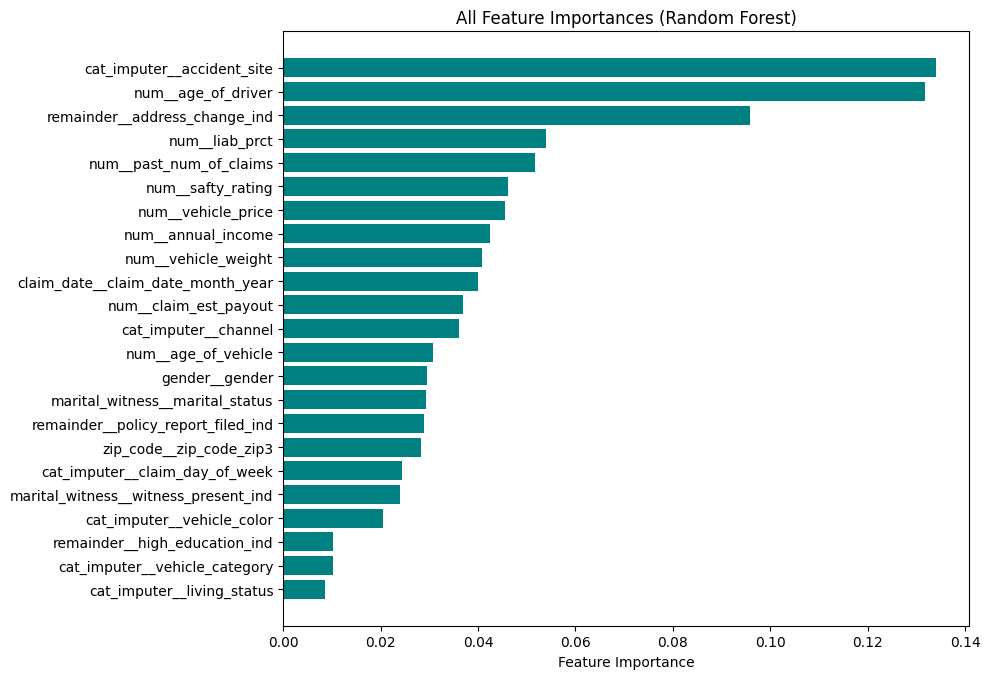

In [10]:
X_test_transformed = preprocessor.transform(X_test)
y_test_proba = final_rf.predict_proba(X_test_transformed)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("測試集績效報告：")
print(classification_report(y_test, y_test_pred))
print(f'auc: {roc_auc:.04f}')
print(f'f2-score: {fbeta_score(y_test, y_test_pred, beta=2):.04f}')

importances = final_rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

fig = plt.gcf()

plt.figure(figsize=(10, len(feat_imp) * 0.3))
plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1], color='teal')
plt.xlabel("Feature Importance")
plt.title("All Feature Importances (Random Forest)")
plt.tight_layout()
save_plot(fig, "feature_importance.png", model_name='rf_halving_feature')
plt.show()

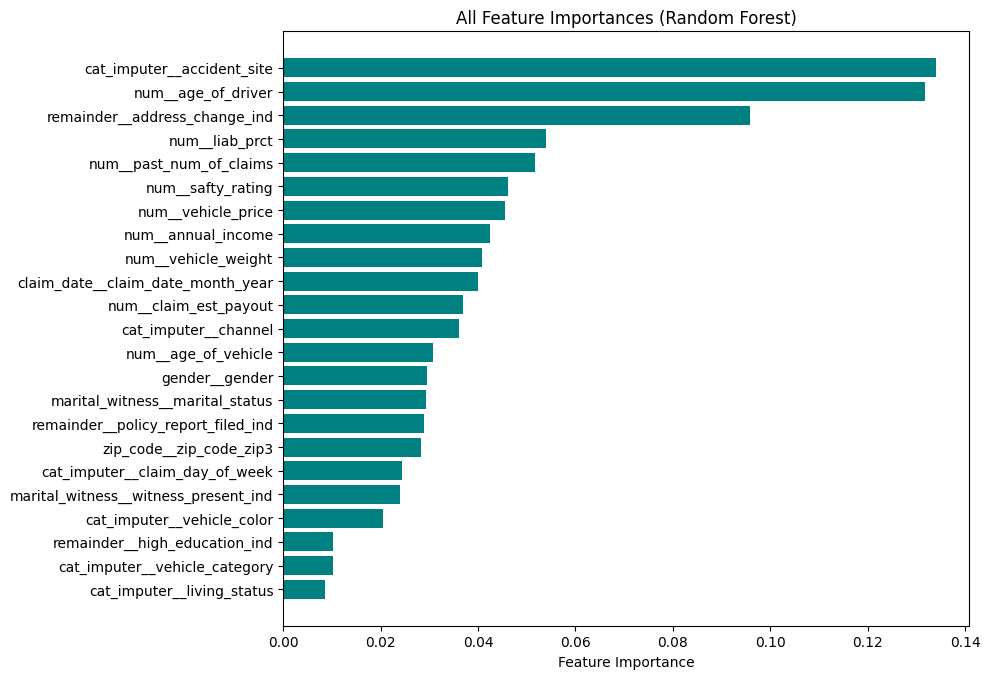

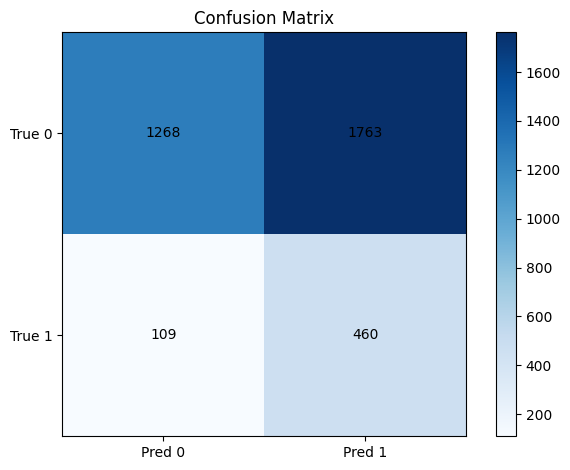

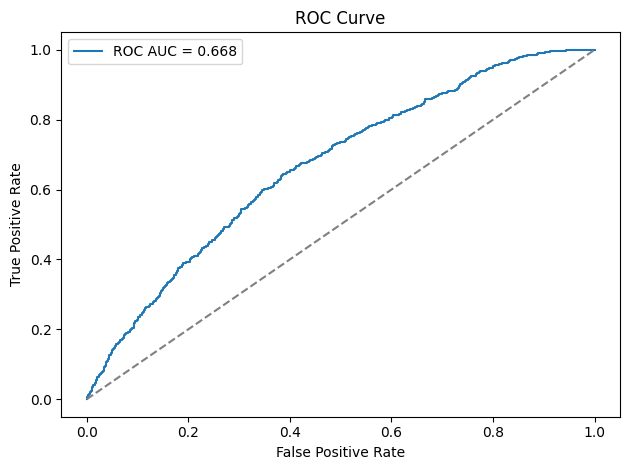

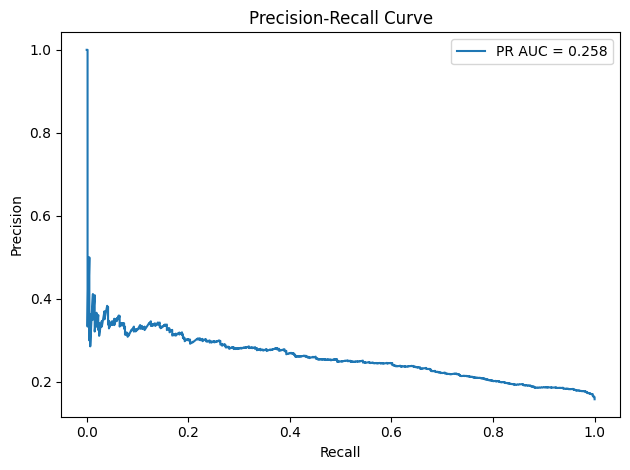

In [11]:
# === 特徵重要性繪圖與儲存 ===
importances = final_rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fig = plt.figure(figsize=(10, len(feat_imp) * 0.3))
plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1], color='teal')
plt.xlabel("Feature Importance")
plt.title("All Feature Importances (Random Forest)")
plt.tight_layout()
save_plot(fig, "feature_importance.png", model_name='rf_halving_feature')
plt.show()

# === 混淆矩陣圖 ===
cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], labels=['Pred 0', 'Pred 1'])
plt.yticks([0, 1], labels=['True 0', 'True 1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout()
save_plot(fig, "confusion_matrix.png", model_name='rf_halving_feature')
plt.show()

# === ROC 曲線 ===
fig = plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
save_plot(fig, "roc_curve.png", model_name='rf_halving_feature')
plt.show()

# === PR 曲線 ===
precision, recall, _ = precision_recall_curve(y_valid, y_proba)
pr_auc = sk_auc(recall, precision)
fig = plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
save_plot(fig, "pr_curve.png", model_name='rf_halving_feature')
plt.show()
